# Tarea Redes Neuronales
## Grupos de 3 personas
### Entregas atrasadas pierden 1 punto por hora. Si alguien entrega a las 00:00:01 implica que pierde 1 punto en la nota final. Recomendación, entregue una versión inicial cerca de las 22 horas y luego suba las modificaciones.

La NASA mantiene la información de varios cometas y quiere determinar alguna manera de predecir el diametro de un cometa. Específicamente, han analizado en forma manual una muestra de 100,000 asteroides. Los datos consisten en 26 variables, con distinta información como por ejemplo nombre del asteroide, su periodo orbital, su periodo de rotación, etc. Todos los datos existentes, se encuentran en un puro archivo llamado asteroidTrain.csv. Mientras que las descripciones de cada una de las variables se encuentran en el archivo tareaInformacion.txt

Desafortunadamente, la NASA todavía no ha evaluado 37.681 asteroides y no tienen tiempo para realizarlo. Por lo mismo, le piden que aplique una red neuronal feed forward para obtener una predicción de estos asteroides.

1. Lea los datos y borre las variables/asteroides que estime necesario. En caso que crea que la base de datos todavía es demasiado grande para aplicar una red neruonal, usted puede tomar una muestra de la misma. NOTA, justifique cada una de las decisiones tomadas, el puntaje principal se basa en las justificaciones. Una vez generado estos datos, guarde la base de datos final en un nuevo archivo csv (1.5 puntos).
2. Entrene un modelo feed forward. Realice una busqueda de hiperparámetros incluyendo número de capas, número de  neuronas, funciones de activación, epocas, etc. Seleccione un modelo final (justificando a través de una evaluación correcta los hiperarametros seleccionados (2.5 puntos). NOTA, justifique cada una de las decisiones tomadas, el puntaje principal se basa en las justificaciones. 
3. Utilice el modelo seleccionado en el punto anterior y evalue los 37,681 asteroides que la NASA no ha evaluado. En este proceso genere un archivo csv de una sola columna con 37,681 filas donde cada celda tendrá el valor del cometa a predecir (2 puntos). Atención, si ustedes entrega un archivo con un número distinto de filas, de igual manera se evaluará las 37,681 filas.

El punto de evaluación final será una competencia entre todas las tareas basados en los MSE más bajos y altos obtenido por cada grupo. El puntaje final será una regresión lineal entre un modelo muy básico y el mejor puntaje.

Para esta entrega usted deberá entregar 4 archivos
1. Un archivo ipynb que muestre todo el proceso de selección de variables y limpieza de datos aplicados. Además, deberá mostrar la búsqueda de hiperparametros. Este archivo ya deberá haber sido ejecutado y cuando se cargué uno debera ver todo el proceso de ejecución. 
2. Un nuevo archivo CSV que contenga la base de datos luego de la limpieza generada en el primer punto de la tarea.
3. Un archivo ipynb limpio que simplemente cargue la nueva base de datos, entrene el modelo con los hiperparametros seleccionados y genere el archivo csv con las 37,681 estimaciones. Este archivo permitirá ver la replicabilidad de su archivo csv. 
4. Un archivo csv con las 37,681 estimaciones realizadas para el modelo.

In [1]:
import numpy as np
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
from plotnine import *
from sklearn.preprocessing import MinMaxScaler

In [2]:
"""
Creates a custom Sequential Multilayer Model
Returns both model and the loss history (model, history)
"""

# model, history = CustomModel(x_train, y_train, 0,[16, 16, 16], "adam", 80, 32)
def CustomModel(x, y, validation_split, hidden_shape, optimizer="adam", epochs=100, batch_size=64):

    hidden_size = len(hidden_shape)
    inputLayer  = tf.keras.layers.Input(shape=(x.shape[1],))
    hiddenLayer = tf.keras.layers.Dense(hidden_shape[0], activation="relu")(inputLayer)
    if hidden_size != 1:
        for shape in hidden_shape[1:hidden_size]:
            hiddenLayer = tf.keras.layers.Dense(shape, activation="relu")(hiddenLayer)
    outputLayer = tf.keras.layers.Dense(1, activation="linear")(hiddenLayer)
    model = tf.keras.Model(inputLayer, outputLayer)

    model.compile(
        optimizer=optimizer,
        loss="mse",
    )

    history = model.fit(
        x,
        y,
        validation_split=validation_split,
        epochs=epochs,
        batch_size=batch_size,
    )

    return model, history


def CleanDataset(filename, hasDiameter=0):
    data = pd.read_csv(filename)

    # Drop columns that have too much NA values
    # Also drops unuseful variables for the model
    data = data.drop(
        columns=[
            "full_name", "G", "extent", "rot_per", "GM", "BV", "UB", "IR", "spec_B", "spec_T", "data_arc", "n_obs_used", "neo", "pha"
        ]
    )

    # Fixes diameter entries if exist (train dataset)
    if hasDiameter == 1:
        # Training
        data = data.dropna(axis=0)
        data["diameter"] = pd.to_numeric(data["diameter"].apply(
            lambda row: "".join(row.split()) if not np.isreal(row) else row)
        )

    return data

# Given a model and its inputs and desired output, fill the NA values of the objective column of a dataframe
def predictna(df, train, objective, model, inputs):
    nadf = df[df[objective].isna()]
    naIndexes = nadf.index
    predictions = model.predict(MinMaxScaler().fit(train[inputs]).transform(nadf[inputs]))
    for i in range(len(naIndexes)):
        df.iloc[naIndexes[i],df.columns.get_loc(objective)] = predictions[i]
    return df

Data

In [3]:
data = CleanDataset("./data/asteroidTrain.csv", 1)
data.info()

C:\Users\satel\AppData\Local\Temp/ipykernel_7804/2392347766.py:35: DtypeWarning: Columns (14,15) have mixed types. Specify dtype option on import or set low_memory=False.


<class 'pandas.core.frame.DataFrame'>
Int64Index: 98923 entries, 0 to 99999
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   a               98923 non-null  float64
 1   e               98923 non-null  float64
 2   i               98923 non-null  float64
 3   om              98923 non-null  float64
 4   w               98923 non-null  float64
 5   q               98923 non-null  float64
 6   ad              98923 non-null  float64
 7   per_y           98923 non-null  float64
 8   condition_code  98923 non-null  float64
 9   H               98923 non-null  float64
 10  diameter        98923 non-null  float64
 11  albedo          98923 non-null  float64
 12  moid            98923 non-null  float64
dtypes: float64(13)
memory usage: 10.6 MB


In [4]:
data.corr().style.background_gradient(cmap='coolwarm')

,a,e,i,om,w,q,ad,per_y,condition_code,H,diameter,albedo,moid
a,1.000000,0.020166,0.145302,0.000658,-0.003933,0.351152,0.986317,0.937645,-0.026619,-0.132851,0.127447,-0.112605,0.354332
e,0.020166,1.000000,0.143870,0.000583,0.011270,-0.530497,0.114542,0.046136,0.008939,0.195409,-0.051190,-0.017886,-0.507399
i,0.145302,0.143870,1.000000,-0.010267,-0.005479,0.090444,0.136373,0.089585,0.194493,-0.037628,0.058741,-0.088043,0.130158
om,0.000658,0.000583,-0.010267,1.000000,-0.108082,-0.003152,0.001245,0.001391,0.019732,0.003394,0.002602,0.000456,-0.003772
w,-0.003933,0.011270,-0.005479,-0.108082,1.000000,-0.008973,-0.002543,-0.001934,0.002218,-0.009784,0.003244,-0.000870,-0.009106
q,0.351152,-0.530497,0.090444,-0.003152,-0.008973,1.000000,0.191987,0.090922,-0.092482,-0.382604,0.288324,-0.270848,0.996853
ad,0.986317,0.114542,0.136373,0.001245,-0.002543,0.191987,1.000000,0.966779,-0.011617,-0.071882,0.082818,-0.070338,0.195874
per_y,0.937645,0.046136,0.089585,0.001391,-0.001934,0.090922,0.966779,1.000000,-0.000725,-0.033252,0.039009,-0.019178,0.092171
condition_code,-0.026619,0.008939,0.194493,0.019732,0.002218,-0.092482,-0.011617,-0.000725,1.000000,0.263350,-0.073075,-0.125296,-0.085426
H,-0.132851,0.195409,-0.037628,0.003394,-0.009784,-0.382604,-0.071882,-0.033252,0.263350,1.000000,-0.581078,-0.242127,-0.378597


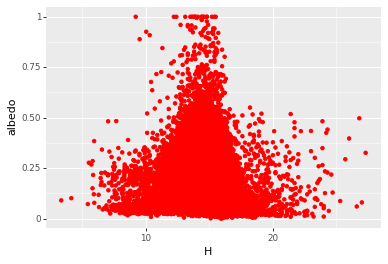

<ggplot: (156489443804)>

In [5]:
ggplot(data)+ \
    aes(x="H",y="albedo")+ \
    geom_point(color="red")

Model

In [6]:
inputColumns = [
    "a",
    "q",
    "H",
    "albedo",
    "moid"
]

x_train = np.array(data[inputColumns])
xscaler = MinMaxScaler()
xscaler.fit(x_train)
x_train = xscaler.transform(x_train)

y_train = np.array(data["diameter"])

In [8]:
model, history = CustomModel(x_train, y_train, 0,[16, 16, 16], "adam", 10, 32)
model.summary()

Epoch 1/10
3092/3092 [==============================] - 7s 2ms/step - loss: 48.1478
Epoch 2/10
3092/3092 [==============================] - 7s 2ms/step - loss: 15.4413
Epoch 3/10
3092/3092 [==============================] - 7s 2ms/step - loss: 10.2943
Epoch 4/10
3092/3092 [==============================] - 7s 2ms/step - loss: 8.5071
Epoch 5/10
3092/3092 [==============================] - 7s 2ms/step - loss: 7.0782
Epoch 6/10
3092/3092 [==============================] - 7s 2ms/step - loss: 6.0991
Epoch 7/10
3092/3092 [==============================] - 7s 2ms/step - loss: 5.4397
Epoch 8/10
3092/3092 [==============================] - 7s 2ms/step - loss: 4.8052
Epoch 9/10
3092/3092 [==============================] - 8s 2ms/step - loss: 4.4268
Epoch 10/10
3092/3092 [==============================] - 8s 3ms/step - loss: 4.2814
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLa

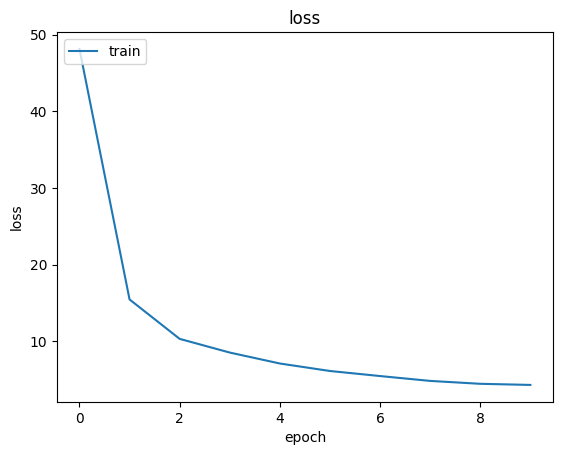

In [9]:
# summarize history for loss
plt.plot(history.history['loss'])
# plt.plot(history.history['val_loss'])
plt.title('loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()

Prediction

In [12]:
from sklearn.metrics import mean_squared_error

evaluate = model.evaluate(x_train, y_train, verbose=0)
mse = mean_squared_error(y_train, model.predict(x_train))

print("eval: %.2f" % evaluate)
print("mse: %.2f" % mse)

eval: 3.66
mse: 3.66


In [13]:
# evaluation = CleanDataset("./data/asteroidEval.csv", 0)
# evaluation = predictna(evaluation, data, "diameter", model, ["a","e","q","moid"])
# evaluation.info()

x_pred = xscaler.transform(data[inputColumns])
y_pred = model.predict(x_pred)
np.savetxt('./data/prediction.csv', y_pred)
y_pred

c:\Users\satel\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\base.py:434: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names


array([[ 5.760965 ],
       [ 4.4565063],
       [ 4.492439 ],
       ...,
       [ 3.9303374],
       [ 3.9470496],
       [36.49002  ]], dtype=float32)